<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/dive-into-deep-learning/pytorch/13-natural-language-processing-pretraining/03-word-embedding-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Dataset for Pretraining Word Embeddings



Now that we know the technical details of 
the word2vec models and approximate training methods,
let us walk through their implementations. 
Specifically,
we will take the skip-gram model
and negative sampling
as an example.

In this section,
we begin with the dataset
for pretraining the word embedding model:
the original format of the data
will be transformed
into minibatches
that can be iterated over during training.

In [ ]:
!wget https://github.com/rahiakela/deep-learning-research-and-practice/raw/main/dive-into-deep-learning/d2l.zip
!unzip d2l.zip

In [2]:
import math
import os
import random
import torch
from d2l import torch as d2l

## Reading the Dataset

The dataset that we use here
is [Penn Tree Bank (PTB)]( https://catalog.ldc.upenn.edu/LDC99T42). 
This corpus is sampled
from Wall Street Journal articles,
split into training, validation, and test sets.
In the original format,
each line of the text file
represents a sentence of words that are separated by spaces.
Here we treat each word as a token.


In [3]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')

def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

After reading the training set,
we build a vocabulary for the corpus,
where any word that appears 
less than 10 times is replaced by 
the "&lt;unk&gt;" token.
Note that the original dataset
also contains "&lt;unk&gt;" tokens that represent rare (unknown) words.


In [4]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## Subsampling

Text data
typically have high-frequency words
such as "the", "a", and "in":
they may even occur billions of times in
very large corpora.
However,
these words often co-occur
with many different words in
context windows, providing little useful signals.
For instance,
consider the word "chip" in a context window:
intuitively
its co-occurrence with a low-frequency word "intel"
is more useful in training
than 
the co-occurrence with a high-frequency word "a".
Moreover, training with vast amounts of (high-frequency) words
is slow.
Thus, when training word embedding models, 
high-frequency words can be *subsampled* :cite:`Mikolov.Sutskever.Chen.ea.2013`.
Specifically, 
each indexed word $w_i$ 
in the dataset will be discarded with probability


$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

where $f(w_i)$ is the ratio of 
the number of words $w_i$
to the total number of words in the dataset, 
and the constant $t$ is a hyperparameter
($10^{-4}$ in the experiment). 
We can see that only when
the relative frequency
$f(w_i) > t$  can the (high-frequency) word $w_i$ be discarded, 
and the higher the relative frequency of the word, 
the greater the probability of being discarded.


In [5]:
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens '<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences], counter)

subsampled, counter = subsample(sentences, vocab)

The following code snippet 
plots the histogram of
the number of tokens per sentence
before and after subsampling.
As expected, 
subsampling significantly shortens sentences
by dropping high-frequency words,
which will lead to training speedup.


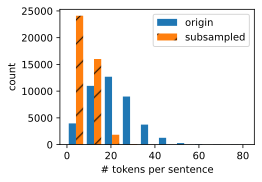

In [6]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence', 'count', sentences, subsampled);

For individual tokens, the sampling rate of the high-frequency word "the" is less than 1/20.


In [7]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2042'

In contrast, 
low-frequency words "join" are completely kept.


In [8]:
compare_counts('join')

'# of "join": before=45, after=45'

In [9]:
compare_counts('love')

'# of "love": before=26, after=26'

After subsampling, we map tokens to their indices for the corpus.


In [10]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2115, 274, 406], [5277, 3054, 1580, 95]]

## Extracting Center Words and Context Words


The following `get_centers_and_contexts`
function extracts all the 
center words and their context words
from `corpus`.
It uniformly samples an integer between 1 and `max_window_size`
at random as the context window size.
For any center word,
those words 
whose distance from it
does not exceed the sampled
context window size
are its context words.


In [ ]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Next, we create an artificial dataset containing two sentences of 7 and 3 words, respectively. 
Let the maximum context window size be 2 
and print all the center words and their context words.


In [ ]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


When training on the PTB dataset,
we set the maximum context window size to 5. 
The following extracts all the center words and their context words in the dataset.


In [ ]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1499193'

## Negative Sampling

We use negative sampling for approximate training. 
To sample noise words according to 
a predefined distribution,
we define the following `RandomGenerator` class,
where the (possibly unnormalized) sampling distribution is passed
via the argument `sampling_weights`.


In [ ]:
#@save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

For example, 
we can draw 10 random variables $X$
among indices 1, 2, and 3
with sampling probabilities $P(X=1)=2/9, P(X=2)=3/9$, and $P(X=3)=4/9$ as follows.


For a pair of center word and context word, 
we randomly sample `K` (5 in the experiment) noise words. According to the suggestions in the word2vec paper,
the sampling probability $P(w)$ of 
a noise word $w$
is 
set to its relative frequency 
in the dictionary
raised to 
the power of 0.75 :cite:`Mikolov.Sutskever.Chen.ea.2013`.


In [ ]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## Loading Training Examples in Minibatches
:label:`subsec_word2vec-minibatch-loading`

After
all the center words
together with their
context words and sampled noise words are extracted,
they will be transformed into 
minibatches of examples
that can be iteratively loaded
during training.



In a minibatch,
the $i^\mathrm{th}$ example includes a center word
and its $n_i$ context words and $m_i$ noise words. 
Due to varying context window sizes,
$n_i+m_i$ varies for different $i$.
Thus,
for each example
we concatenate its context words and noise words in 
the `contexts_negatives` variable,
and pad zeros until the concatenation length
reaches $\max_i n_i+m_i$ (`max_len`).
To exclude paddings
in the calculation of the loss,
we define a mask variable `masks`.
There is a one-to-one correspondence
between elements in `masks` and elements in `contexts_negatives`,
where zeros (otherwise ones) in `masks` correspond to paddings in `contexts_negatives`.


To distinguish between positive and negative examples,
we separate context words from noise words in  `contexts_negatives` via a `labels` variable. 
Similar to `masks`,
there is also a one-to-one correspondence
between elements in `labels` and elements in `contexts_negatives`,
where ones (otherwise zeros) in `labels` correspond to context words (positive examples) in `contexts_negatives`.


The above idea is implemented in the following `batchify` function.
Its input `data` is a list with length
equal to the batch size,
where each element is an example
consisting of
the center word `center`, its context words `context`, and its noise words `negative`.
This function returns 
a minibatch that can be loaded for calculations 
during training,
such as including the mask variable.


In [ ]:
#@save
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

Let us test this function using a minibatch of two examples.


In [ ]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## Putting All Things Together

Last, we define the `load_data_ptb` function that reads the PTB dataset and returns the data iterator and the vocabulary.


In [ ]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

Let us print the first minibatch of the data iterator.


In [ ]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


## Summary

* High-frequency words may not be so useful in training. We can subsample them for speedup in training.
* For computational efficiency, we load examples in minibatches. We can define other variables to distinguish paddings from non-paddings, and positive examples from negative ones.



## Exercises

1. How does the running time of code in this section changes if not using subsampling?
1. The `RandomGenerator` class caches `k` random sampling results. Set `k` to other values and see how it affects the data loading speed.
1. What other hyperparameters in the code of this section may affect the data loading speed?


[Discussions](https://discuss.d2l.ai/t/1330)
